In [2]:
# https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

In [3]:
# https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [4]:
from tensorflow.keras import mixed_precision

# Equivalent to the two lines above
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2080, compute capability 7.5


In [129]:
# import the necessary packages
# from pyimagesearch import config
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer, MinMaxScaler

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.utils import shuffle


import PIL

In [6]:
plt.rcParams['figure.figsize'] = 20, 10

# Getting Label Data and Image IDs

In [7]:
complete_data = pd.read_csv('../../../../WikiArt-Emotions/WikiArt-Emotions-All.tsv', sep='\t')

In [8]:
complete_data.head()

,ID,Style,Category,Artist,Title,Year,Image URL,Painting Info URL,Artist Info URL,Is painting,...,TitleOnly: love,TitleOnly: optimism,TitleOnly: pessimism,TitleOnly: regret,TitleOnly: sadness,TitleOnly: shame,TitleOnly: shyness,TitleOnly: surprise,TitleOnly: trust,TitleOnly: neutral
0,58c6237dedc2c9c7dc0de1ae,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://use2-uploads3.wikiart.org/00123/images...,https://www.wikiart.org/en/charles-courtney-cu...,https://www.wikiart.org/en/charles-courtney-cu...,yes,...,0.155,0.238,0.024,0.012,0.024,0.012,0.000,0.048,0.155,0.0
1,577280dfedc2cb3880f28e76,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://use2-uploads1.wikiart.org/images/keith...,https://www.wikiart.org/en/keith-haring/the-ma...,https://www.wikiart.org/en/keith-haring,yes,...,0.200,0.000,0.100,0.000,0.000,0.000,0.000,0.200,0.000,0.0
2,57727f2dedc2cb3880ed5fa9,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://use2-uploads3.wikiart.org/images/j-zse...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,https://www.wikiart.org/en/jozsef-rippl-ronai,yes,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.100,0.0
3,58d1240cedc2c94f900fc610,Modern Art,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://use2-uploads2.wikiart.org/00124/images...,https://www.wikiart.org/en/vadym-meller/monk-f...,https://www.wikiart.org/en/vadym-meller,yes,...,0.091,0.091,0.000,0.000,0.091,0.000,0.091,0.182,0.091,0.0
4,57727de7edc2cb3880e91f26,Post Renaissance Art,Romanticism,David Wilkie,The Defence of Sarago&#231;a,1828,https://use2-uploads6.wikiart.org/images/david...,https://www.wikiart.org/en/david-wilkie/the-de...,https://www.wikiart.org/en/david-wilkie,yes,...,0.077,0.231,0.077,0.077,0.154,0.077,0.077,0.154,0.385,0.0


In [9]:
labels_cols = [col for col in complete_data.columns if 'ImageOnly:' in col]

In [10]:
id_and_labels_pd = complete_data[['ID'] + labels_cols].rename(columns=lambda x: x.replace('ImageOnly: ', '')).copy()

In [11]:
FINAL_LABEL_COLS = [col for col in id_and_labels_pd.columns if col != 'ID']

In [12]:
id_and_labels_pd.head()

,ID,agreeableness,anger,anticipation,arrogance,disagreeableness,disgust,fear,gratitude,happiness,...,love,optimism,pessimism,regret,sadness,shame,shyness,surprise,trust,neutral
0,58c6237dedc2c9c7dc0de1ae,0.060,0.012,0.071,0.024,0.012,0.000,0.012,0.119,0.726,...,0.250,0.274,0.012,0.000,0.131,0.000,0.024,0.024,0.250,0.0
1,577280dfedc2cb3880f28e76,0.000,0.000,0.100,0.000,0.000,0.100,0.300,0.000,0.100,...,0.000,0.200,0.200,0.100,0.200,0.000,0.000,0.500,0.000,0.0
2,57727f2dedc2cb3880ed5fa9,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.100,0.500,...,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.0
3,58d1240cedc2c94f900fc610,0.000,0.000,0.091,0.000,0.000,0.091,0.000,0.000,0.091,...,0.000,0.000,0.182,0.000,0.364,0.000,0.000,0.273,0.000,0.0
4,57727de7edc2cb3880e91f26,0.077,0.077,0.077,0.231,0.308,0.308,0.308,0.231,0.154,...,0.077,0.231,0.231,0.077,0.231,0.154,0.077,0.154,0.231,0.0


In [13]:
id_and_labels_pd.describe().T[['mean','50%','min','max']]

,mean,50%,min,max
agreeableness,0.031336,0.000,0.0,0.400
anger,0.034361,0.000,0.0,0.727
anticipation,0.192566,0.182,0.0,0.818
arrogance,0.045590,0.000,0.0,0.800
disagreeableness,0.035555,0.000,0.0,0.700
disgust,0.069845,0.012,0.0,0.727
fear,0.109806,0.060,0.0,1.000
gratitude,0.049602,0.000,0.0,0.545
happiness,0.242745,0.182,0.0,1.000
humility,0.140305,0.100,0.0,0.800


<AxesSubplot:>

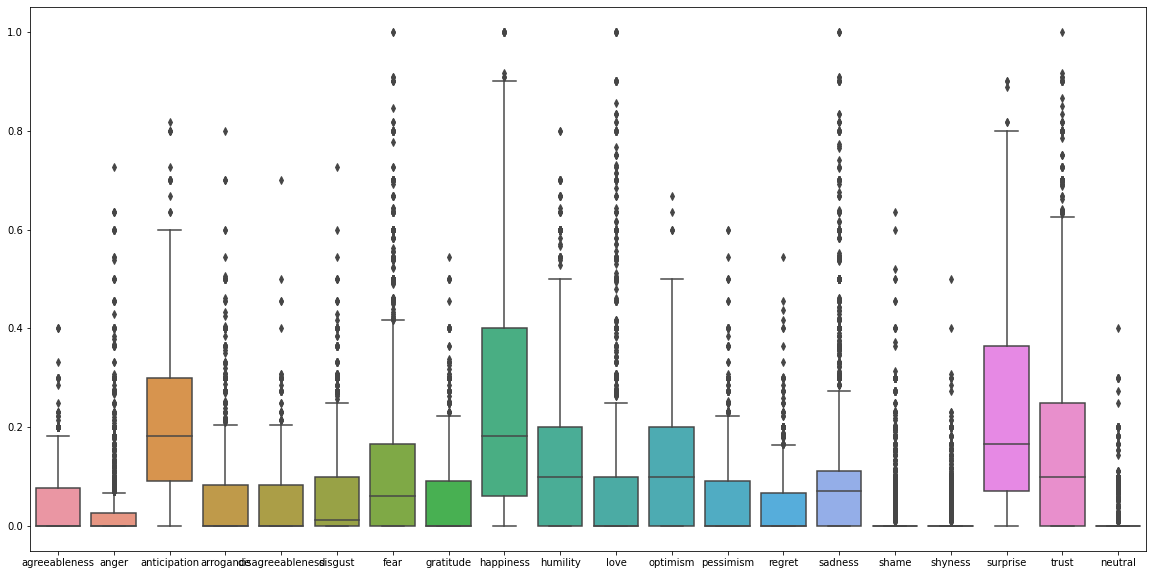

In [14]:
sns.boxplot(data=id_and_labels_pd[FINAL_LABEL_COLS])

<AxesSubplot:>

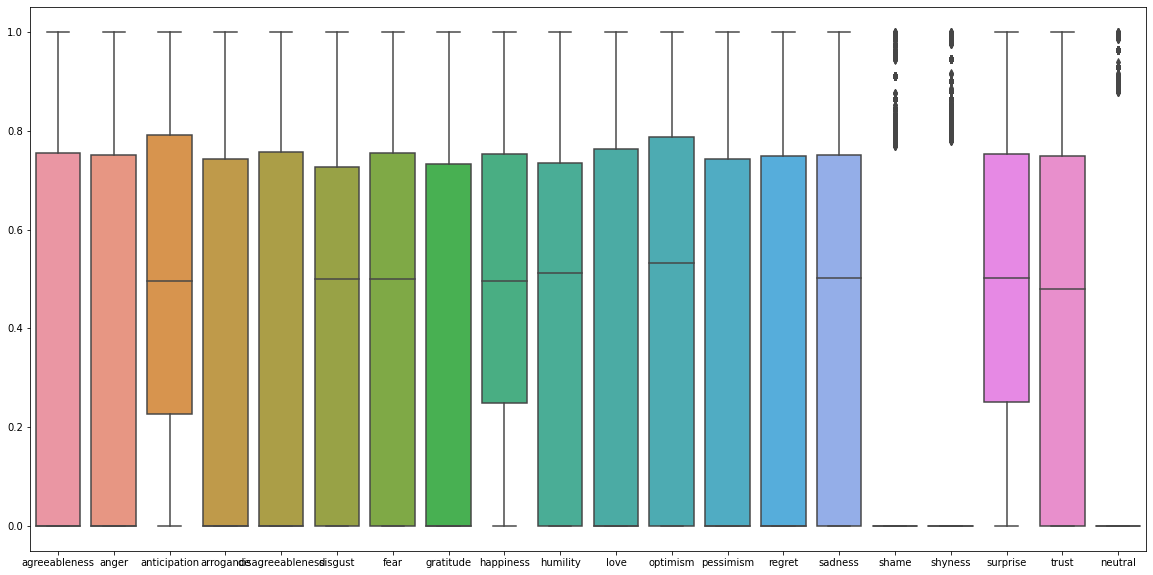

In [131]:
sns.boxplot(data=pd.DataFrame(id_and_labels_pd[FINAL_LABEL_COLS].pipe(QuantileTransformer().fit_transform), columns=FINAL_LABEL_COLS))

# Getting Images

In [15]:
def get_wikiart_img_path(img_id, root_path='../../../../WikiArt-Emotions/images', suffix='.jpg'):
    return f'{root_path}/{img_id}{suffix}'

In [16]:
test_img_path = get_wikiart_img_path('58c6237dedc2c9c7dc0de1ae')

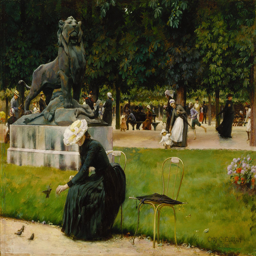

In [17]:
PIL.Image.open(test_img_path).resize((256, 256))

In [18]:
paths = list(id_and_labels_pd['ID'].apply(get_wikiart_img_path).values)

In [19]:
id_and_labels_pd['image_path'] = paths

# Defining Preprocessing

In [20]:
# initialize the training training data augmentation object
train_augmentation = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
val_augmentation = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")

train_augmentation.mean = mean
val_augmentation.mean = mean

# Splitting

In [21]:
def get_train_test_and_validation(dataframe, train_pct=0.75, val_pct=0.1, random_state=None):
    dataframe_shuffled = shuffle(dataframe, random_state=random_state).copy()
    
    train_split_idx = int(len(dataframe_shuffled) * train_pct)
    
    complete_train_df = dataframe_shuffled.iloc[:train_split_idx]
    test_df = dataframe_shuffled.iloc[train_split_idx:]
    
    val_split_idx = int(len(complete_train_df) * val_pct)
    val_df = complete_train_df.iloc[:val_split_idx]
    train_df = complete_train_df.iloc[val_split_idx:]
    
    return train_df, val_df, test_df

In [22]:
len(pd.concat(get_train_test_and_validation(id_and_labels_pd))) # it werks!

4105

In [23]:
train_df, val_df, test_df = get_train_test_and_validation(id_and_labels_pd)

### Preprocessing Y

In [132]:
transformer = QuantileTransformer()

In [133]:
train_df[FINAL_LABEL_COLS] = transformer.fit_transform(train_df[FINAL_LABEL_COLS])

In [134]:
val_df[FINAL_LABEL_COLS] = transformer.transform(val_df[FINAL_LABEL_COLS])
test_df[FINAL_LABEL_COLS] = transformer.transform(test_df[FINAL_LABEL_COLS])

In [135]:
total_train = len(train_df)
total_test = len(test_df)
total_val = len(val_df)

In [136]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

2771
307
1027


In [137]:
train_generator = train_augmentation.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col=FINAL_LABEL_COLS,
    class_mode='raw', # modelaremos inicialmente directamente con el input del dataframe
)

val_generator = val_augmentation.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col=FINAL_LABEL_COLS,
    class_mode='raw', # modelaremos inicialmente directamente con el input del dataframe
)

Found 2765 validated image filenames.
Found 307 validated image filenames.


/home/goviedb/python_venv/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 6 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [138]:
test_generator = val_augmentation.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col=FINAL_LABEL_COLS,
    class_mode='raw', # modelaremos inicialmente directamente con el input del dataframe
    shuffle=False # queremos recuperar los labels en orden
)

Found 1027 validated image filenames.


In [61]:
test_map = test_df[['ID','image_path']].set_index('image_path')['ID'].to_dict()

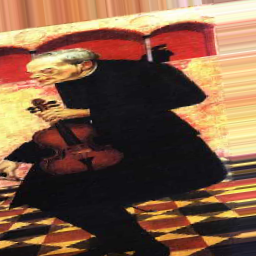

In [27]:
PIL.Image.fromarray(train_generator.next()[0][0].astype(np.uint8)) # it werks

# Define Model and Train

In [147]:
INIT_LR = 1e-4
BS = 512
NUM_EPOCHS = 40

def define_resnet50_transfer_learning_model():
    baseModel = ResNet50(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3)))
    
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(len(FINAL_LABEL_COLS), dtype='float32', activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False
        
    return model

In [144]:
model = define_resnet50_transfer_learning_model()

In [145]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [146]:
# compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)

# modelamos los valores directamente, asi que mean_absolute_error (just in case por los outliers)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mean_absolute_error"])

# train the model
H = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BS,
    validation_data=val_generator,
    validation_steps=total_val // BS,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/40
21/21 [==============================] - 14s 570ms/step - loss: 0.3323 - mean_absolute_error: 0.3323 - val_loss: 0.2941 - val_mean_absolute_error: 0.2941
Epoch 2/40
21/21 [==============================] - 12s 586ms/step - loss: 0.3236 - mean_absolute_error: 0.3236 - val_loss: 0.3262 - val_mean_absolute_error: 0.3262
Epoch 3/40
21/21 [==============================] - 11s 550ms/step - loss: 0.3219 - mean_absolute_error: 0.3219 - val_loss: 0.3187 - val_mean_absolute_error: 0.3187
Epoch 4/40
21/21 [==============================] - 11s 537ms/step - loss: 0.3240 - mean_absolute_error: 0.3240 - val_loss: 0.3123 - val_mean_absolute_error: 0.3123
Epoch 5/40
21/21 [==============================] - 11s 544ms/step - loss: 0.3156 - mean_absolute_error: 0.3156 - val_loss: 0.3107 - val_mean_absolute_error: 0.3107
Epoch 6/40
21/21 [==============================] - 10s 495ms/step - loss: 0.3136 - mean_absolute_error: 0.3136 - val_loss: 0.3166 - val_mean_absolute_error: 0.3166
Epoch 7/40

KeyboardInterrupt: 

In [ ]:
mo

In [34]:
model.evaluate_generator(test_generator)

/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.06578262895345688, 0.06578262895345688]

In [42]:
test_predict = model.predict_generator(test_generator)

In [71]:
pd_test_predict = pd.DataFrame(test_predict, columns=FINAL_LABEL_COLS)

In [72]:
pd_test_predict['image_path'] = test_generator.filenames

In [73]:
pd_test_predict['ID'] = pd_test_predict['image_path'].map(test_map)

In [74]:
FINAL_LABEL_COLS

['agreeableness',
 'anger',
 'anticipation',
 'arrogance',
 'disagreeableness',
 'disgust',
 'fear',
 'gratitude',
 'happiness',
 'humility',
 'love',
 'optimism',
 'pessimism',
 'regret',
 'sadness',
 'shame',
 'shyness',
 'surprise',
 'trust',
 'neutral']

In [99]:
emotion_to_check = 'love'
pd_test_predict.sort_values(by=emotion_to_check)[['image_path',emotion_to_check]]

,image_path,love
729,../../../../WikiArt-Emotions/images/57728364ed...,0.000005
841,../../../../WikiArt-Emotions/images/57727f04ed...,0.000009
925,../../../../WikiArt-Emotions/images/57727f6aed...,0.000009
966,../../../../WikiArt-Emotions/images/57727f76ed...,0.000011
655,../../../../WikiArt-Emotions/images/577270a3ed...,0.000012
...,...,...
827,../../../../WikiArt-Emotions/images/577286caed...,0.011869
989,../../../../WikiArt-Emotions/images/57727be1ed...,0.011943
194,../../../../WikiArt-Emotions/images/577284aeed...,0.012756
198,../../../../WikiArt-Emotions/images/57728984ed...,0.012938


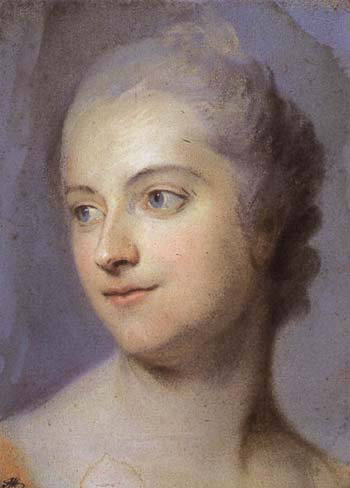

In [104]:
file_path_to_check = pd_test_predict.sort_values(by=emotion_to_check)[['image_path',emotion_to_check]].iloc[-4]['image_path']
PIL.Image.open(file_path_to_check)

# Applying to new data

In [ ]:
new_data_augmentation = ImageDataGenerator()


In [31]:
#model.save('experiment_2.pkl')

INFO:tensorflow:Assets written to: experiment_1.pkl/assets
